## Terminology

- **Chemical composition** (or composition for short) refers to the types and counts of atoms in a structure. Examples:
    - Water ($\text{H}_2\text{O}$) has a composition of $\{\text{H}: 2, \text{O}: 1\}$.
    - Methylamine ($\text{CH}_3\text{NH}_2$) has a composition of $\{\text{C}: 1, \text{H}: 5, \text{N}: 1\}$.
- **Structure** refers to the spatial arrangement of atoms in a material (i.e., composition + 3D coordinates).

# Property Datasets

- Contain snapshots of (usually near-equilibrium) structures and atomic properties of interest. Examples:
    - Crystal structures and formation energies.
    - Metal-organic frameworks and band gaps.
- Usually diverse in chemical composition, but not necessarily in structure (for a given composition).
- **Splitting methods**:
    - Random: Randomly assign structures to train/val/test.
    - OOD composition: Ensure test set contains novel compositions.
    - Stratified (kind of): Ensure that all compositions are represented in train/val/test.
- Example:
    - QM9: ~130k small organic molecules with 3D coordinates and 12 properties. **Random** split.

# Force-field datasets

- Contain snapshots of molecular systems at different time points. Examples:
    - DFT (Density Functional Theory) relaxation trajectories.
    - Molecular dynamics simulations.
- Usually diverse in structure (for a given composition), but not necessarily in chemical composition.
- **Splitting methods**:
    - OOD trajectory: Randomly assign trajectories to train/val/test, ensuring that train/val/test are from different trajectories.
    - ID trajectory: Randomly assign frames to train/val/test, allowing for the same trajectory in train/val/test.
    - **Same** trajectory: Train/val/test are all from the same trajectory. This happens when the dataset only contains one trajectory (e.g., MD17, MD22).
    - OOD composition: Ensure test set contains novel compositions.
    - Stratified (kind of): Ensure that all compositions are represented in train/val/test. Never seen this in practice.

## MD17: Molecular dynamics trajectories of small molecules.

- Small dataset with limited chemical diversity and system size.
- Different model trained for each molecule.
- Train/val/test are both on **the same exact trajectory**.
- Example: https://youtu.be/Ow79mbbv7tY

<iframe width="560" height="315" src="https://www.youtube.com/embed/Ow79mbbv7tY?si=1QoRStBr-w7tkVX3&amp;controls=0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## COLL: Molecular dynamics simulations of molecular collisions.
- Small dataset with limited chemical diversity and system size.
- Train/val/test can contain points from the same trajectory.
- Example: Figure 3 of https://arxiv.org/pdf/2011.14115.pdf

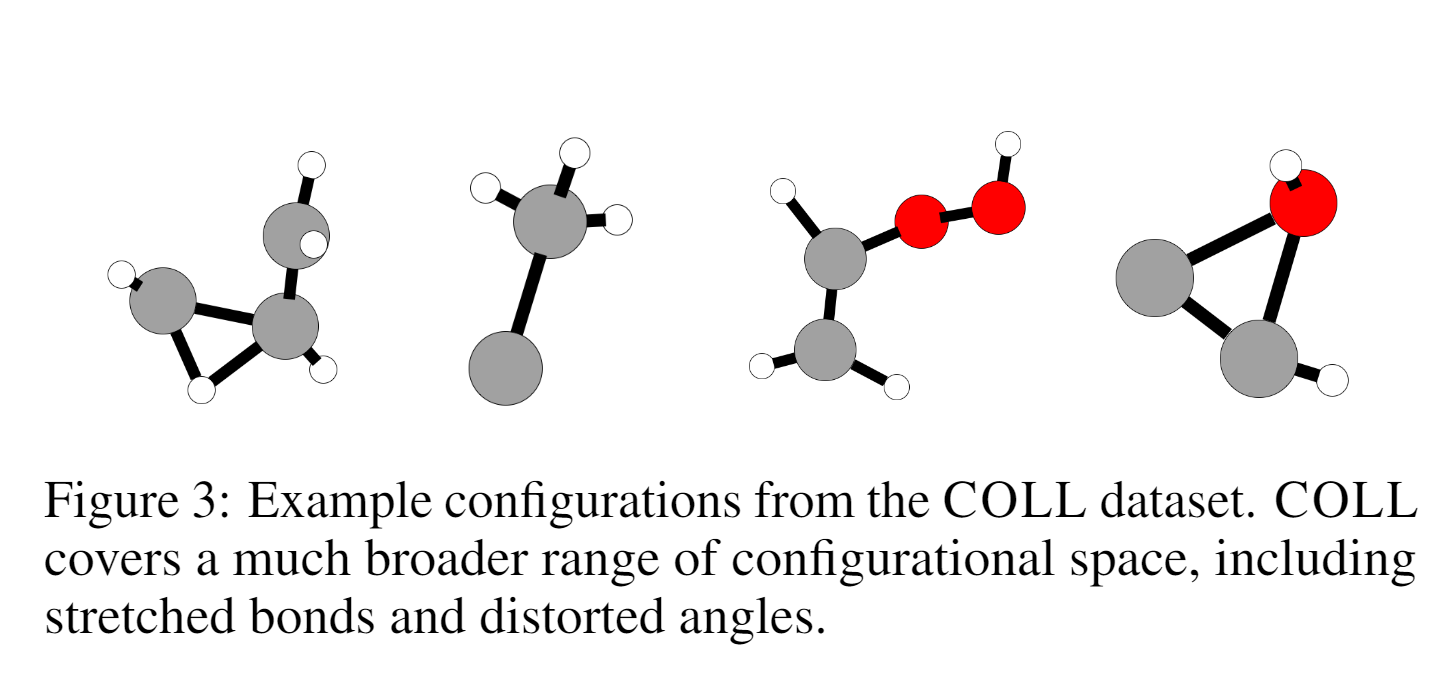

## OC20: Open Catalyst 2020 dataset.

- Large dataset with high chemical diversity and system size.
- Each system comprises of a catalyst and adsorbate.
- ID can contain points from the same trajectory, but OOD contains novel compositions.
- Three notions of OOD:
    - OOD adsorbate: Leave out some adsorbates from training.
    - OOD catalyst: Leave out some catalyst **compositions** (i.e., atomic number counts) from training.
    - OOD both: OOD adsorbates + OOD catalysts.
- Example: https://opencatalystproject.org/assets/videos/oh_system.mp4

<video controls src="https://opencatalystproject.org/assets/videos/oh_system.mp4" />

# TL;DR

The following splitting strategies are most common:
- **Random**: Used when the dataset is a near-equilibrium dataset (i.e., no trajectories).
- **ID trajectory** and **OOD trajectory**: Used when the dataset contains multiple trajectories (e.g., COLL, OC20).
- **Same trajectory**: Used when the dataset contains a single trajectory.

# GemNet OC Paper Review

- Graph Neural Networks (GNNs) have achieved state-of-the-art performance on molecular property prediction tasks. However, most progress has been demonstrated on small datasets covering limited chemical spaces.
- There is a question of whether model improvements on small, narrow datasets translate well to large, diverse molecular datasets. This is important for scaling GNN success to realistic chemical problems.

## Dataset and Tasks

The paper identifies the following key dataset aspects that determine difficulty:

1. Chemical diversity: The number of distinct elements and chemical environments present in the data. More diversity requires models to learn more complex atomic interactions.
2. System size: The number of atoms per structure. Larger systems can have longer-range interactions and many-body effects that are challenging to model.
3. Dataset size: The number of training examples. Larger datasets can support training higher capacity models and provide better coverage of chemical space.
4. Domain shift: The difference between training and test distributions. Larger shifts require models to extrapolate further from their training data.

Based on these aspects, the authors experiment with the following datasets to isolate their effects (see table 1 of GemNet-OC paper):

- MD17
- COLL
- Six OC20 Data Subsets:
    1. OC-Rb and OC-Sn: These subsets restrict the data to only structures containing Rb (rubidium) or Sn (tin) catalyst atoms respectively. This limits the chemical diversity to only 15 possible atomic neighbor pairs, compared to 1454 in the full OC20 data. The authors chose Rb and Sn as they are among the most frequent catalyst elements in OC20.

    2. OC-sub30: This subset filters the data to only include structures with at most 30 atoms. This reduces the average system size from 73 to 25 atoms, while still preserving the diversity of atomic environments due to OC20's use of periodic boundary conditions.

    3. OC-200k and OC-2M: These are random subsets of 200,000 and 2,000,000 structures from the full OC20 training set (which has 134M examples). They maintain the chemical diversity and system size of the full set, but vary the dataset size to observe its impact on model trends.

    4. OC-XS: This subset combines the restrictions of OC-Rb (only Rb catalysts) and OC-sub30 (max 30 atoms), while using all OC-Rb structures. This results in a smaller, simpler subset with reduced diversity, system size, and dataset size.

## Findings

- The authors find model choices can have very different, even opposite effects between small/narrow datasets vs OC20. All 4 dataset aspects can drive these differences.
- Most Importantly, only the OC-2M subset provides model trends that correlate very well with the full OC20 dataset, while being much faster to experiment on. This suggests that the other aspects are crucial for the generalization of the model.

# $\Delta$-Learning and "Linear Referencing" Approach

Normalization schemes have been known to aid in accelerating and improving model training, particularly for deep neural networks. The OC22 paper present a "linear referencing" approach. First, we fit a linear regression model to learn per-atom energies, i.e.

$$
\begin{align*}
    \mathbf{K} &= \begin{bmatrix}
K^1_H & K^1_{He} & K^1_{Li} & \dots & K^1_{Fm}\\
K^2_H & K^2_{He} & K^2_{Li} & \dots & K^2_{Fm}\\
\vdots & \vdots & \vdots & \vdots & \vdots &\\
K^N_H & K^N_{He} & K^N_{Li} & \dots & K^N_{Fm}\\
\end{bmatrix}, \mathbf{P} = \begin{bmatrix}
E_H\\
E_{He}\\
\vdots\\
E_{Fm}
\end{bmatrix}
\end{align*}
$$

$$
\mathbf{K}\mathbf{P} = \begin{bmatrix}
E^{DFT}_1\\
E^{DFT}_2\\
\vdots\\
E^{DFT}_N
\end{bmatrix}
$$

Where:
- $N$ is the total number of systems
- $\mathbf{K}^{i}_{j}$ corresponds to the count of element $j$ in system $i$
- $\mathbf{E}_j$ the per-element energy being fit
- $\mathbf{E}^{DFT}_i$ the ground truth DFT total energy

Once fitted, energy targets used for training, $\mathbf{E}^{ML}_i$, are referenced as follows:

$$
\mathbf{E}^{ML}_{i} = \mathbf{E}^{DFT}_i - \mathbf{K}^{i}\mathbf{P}
$$

Where:
- $\mathbf{K^{i}}$ are the element counts for system $i$
- $\mathbf{P}$ is the set of fitted per-element energy coefficients

## Intuitive Explanation

The $\Delta$-Learning approach works as follows: instead of directly predicting the total energy of a system, the model learns to predict the $\Delta$-energy needed to correct a naive prediction made by a linear regression model that predicts the total energy from the composition (i.e., the counts of each element in the system). This approach has the advantage of normalizing the energy predictions, making the learning task easier for the model.

By training the model to predict these energy differences, we are effectively normalizing the energy predictions with respect to the reference state. This normalization can help stabilize and accelerate the training process, especially for deep neural networks. Additionally, it can improve the model's ability to generalize to new systems by removing the need to explicitly model the absolute energy scale.

# Results: OC22

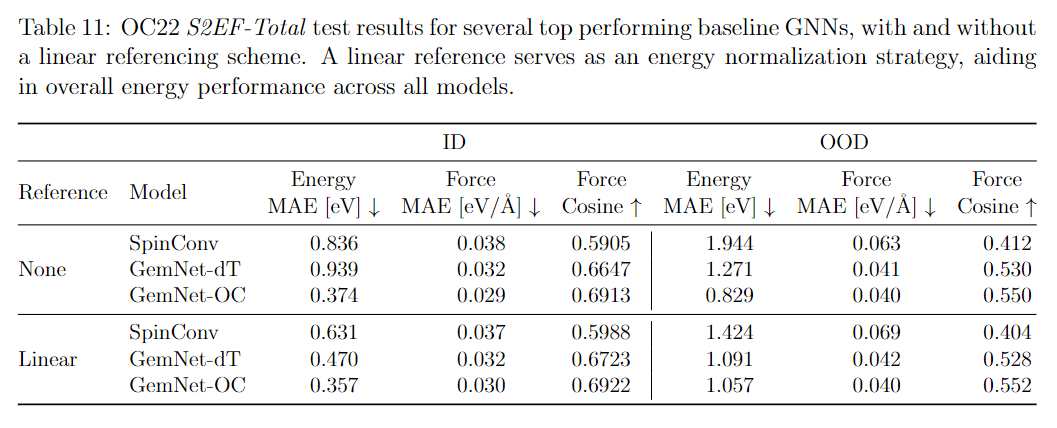

In [4]:
import nshtrainer.ll as ll
from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.data import Data
from tqdm.auto import tqdm
from jmppeft.tasks.finetune import dataset_config as DC

ll.pretty()


def get_energies(dataset):
    def collate_fn(data_list: list[Data]):
        return np.stack([data.y.float().numpy() for data in data_list], axis=0)

    dataloader = DataLoader(
        dataset,
        batch_size=256,
        collate_fn=collate_fn,
        pin_memory=False,
        num_workers=0,
    )

    energies_list: list[np.ndarray] = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        energies_list.append(batch)

    return np.concatenate(energies_list, axis=0)


base_path = Path("/mnt/datasets/matbench-discovery-traj/megnet-133k-npz/")
energies_linref = get_energies(
    DC.matbench_discovery_config(
        base_path,
        "val",
        use_megnet_133k=True,
        use_atoms_metadata=True,
        use_linref=True,
    ).create_dataset()
)
energies_no_linref = get_energies(
    DC.matbench_discovery_config(
        base_path,
        "val",
        use_megnet_133k=True,
        use_atoms_metadata=True,
        use_linref=False,
    ).create_dataset()
)
print(energies_linref, energies_no_linref)

# Linear Referencing Demonstration

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

array[9384] f32 37Kb x∈[-223.425, 2.749e+03] μ=0.878 σ=41.384 array[9384] f32 37Kb x∈[-1.785e+03, 2.470e+03] μ=-184.949 σ=193.735


# Linear Referencing Demonstration

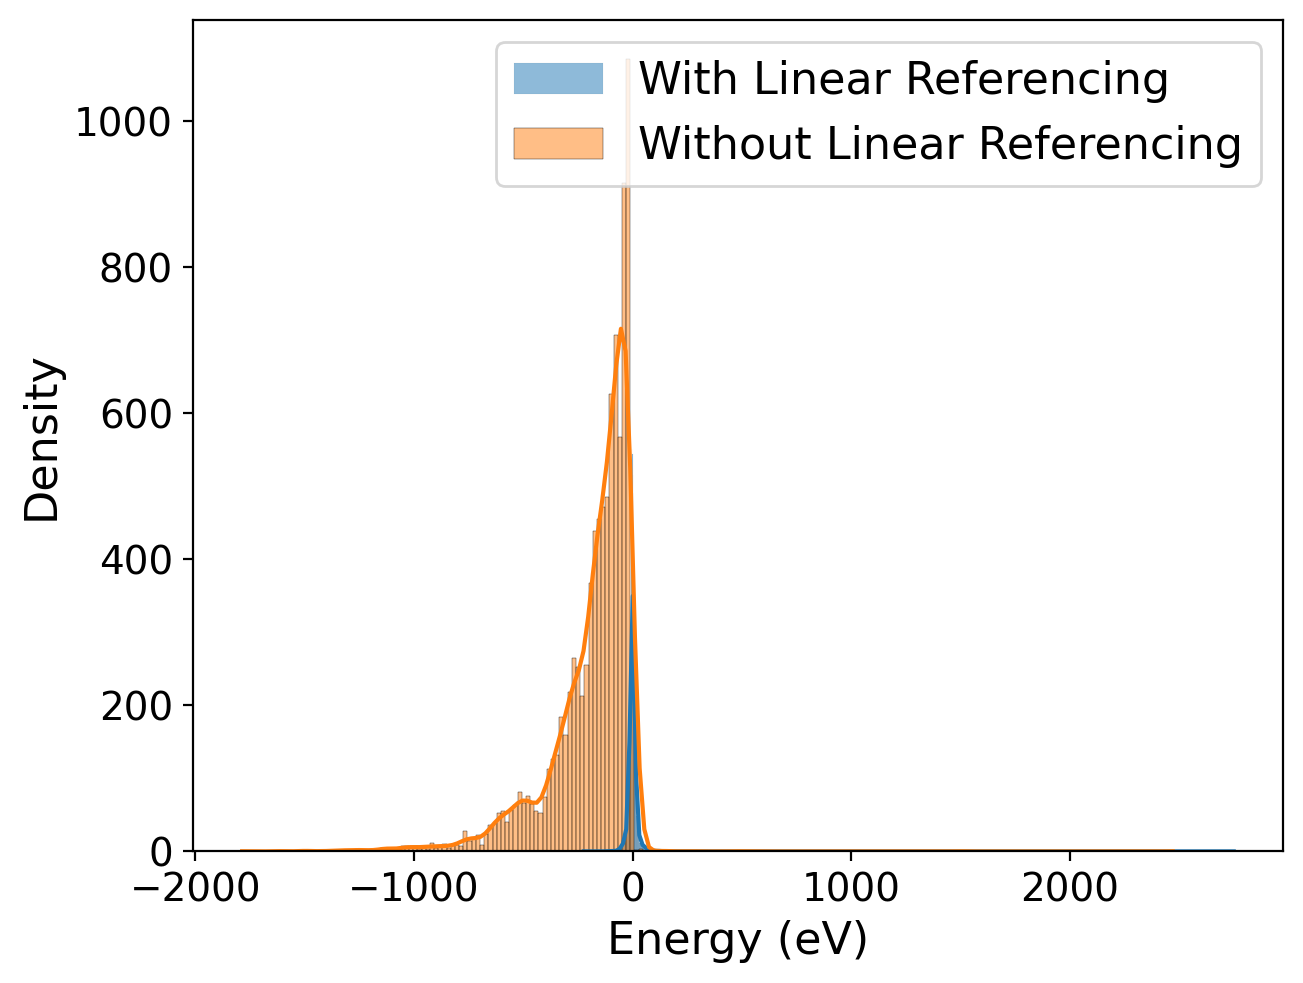

In [41]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

display(Markdown("# Linear Referencing Demonstration"))

fig, axes = plt.subplots()
ax = axes
sns.histplot(energies_linref, label="With Linear Referencing", ax=ax, kde=True)
sns.histplot(energies_no_linref, label="Without Linear Referencing", ax=ax, kde=True)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Density")
plt.legend()
plt.show()